In [1]:
import tensorflow as tf

import utils as u
import h5py
import itertools
from time import time
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU,UpSampling2D
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard


import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'
input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape




input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    a=np.random.randint(input_images.shape[2]-5)
    b=np.random.randint(input_images.shape[1]-5)

    xdim=(a,a+5)
    ydim=(b,b+5)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''

#im=plt.imshow(input_images[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#
#im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
#         #as opposed to plt.close which closes the window. If you are showing many images at a time without
#         #closing the window it is better.
#
#im=plt.imshow(deadregion_image[1],cmap=cm.coolwarm)
#plt.show()
#plt.clf()
#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))




sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)


print sample.shape


X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
Y=[]
yw=['good','hot','dead']

(999, 72, 84)
(999, 72, 32)
Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)

(2997, 72, 32)


In [4]:
for i in range(3):
    for k in range(input_images.shape[0]):
        Y.append(yw[i])
    #print Y
print 'out of loop',Y
print len(Y)

out of loop ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'go

X shape is:  (2997, 72, 32)
Y length is:  2997
Xtrain.shape (700, 72, 32)
ytrain.shape 700
Xval.shape (689, 72, 32)
yval.shape 689
Xtest.shape (1608, 72, 32)
ytest.shape 1608
Printing labels and their corresponding images
-------------------
good


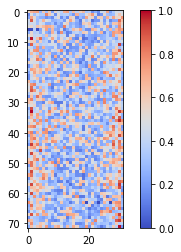

-------------------
good


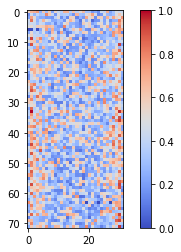

-------------------
dead


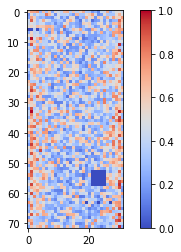

-------------------
dead


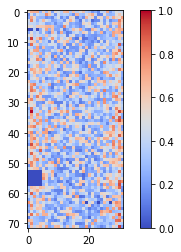

-------------------
dead


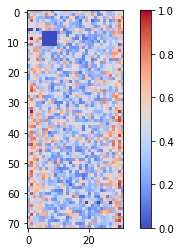

-------------------
hot


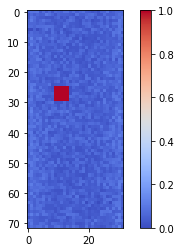

-------------------
hot


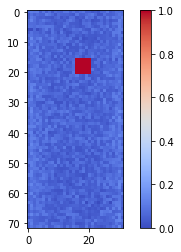

-------------------
dead


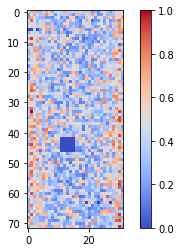

-------------------
good


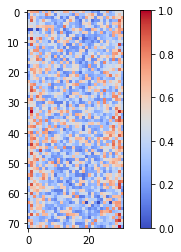

-------------------
good


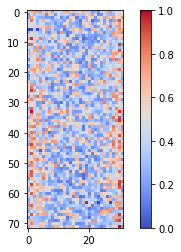

-------------------
hot


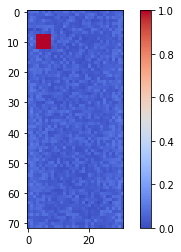

-------------------
hot


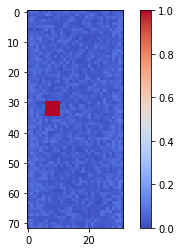

-------------------
dead


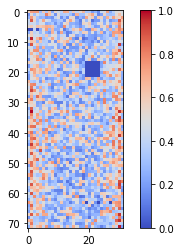

-------------------
hot


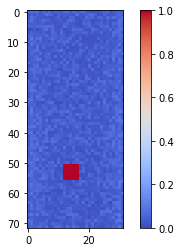

-------------------
dead


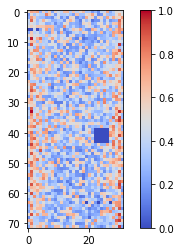

-------------------
dead


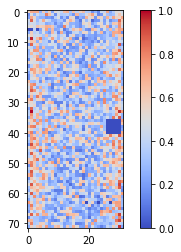

-------------------
dead


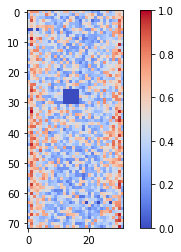

-------------------
hot


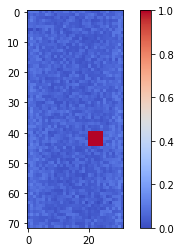

-------------------
hot


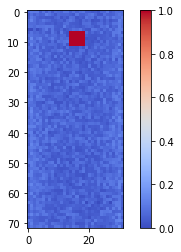

-------------------
hot


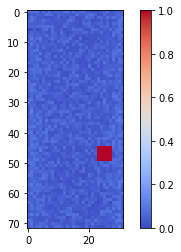

-------------------
hot


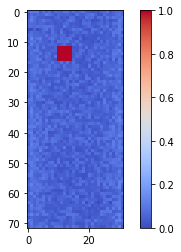

-------------------
dead


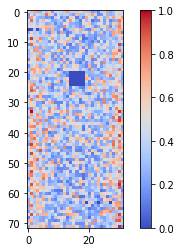

-------------------
dead


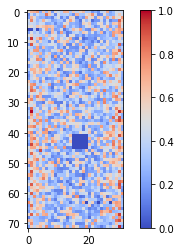

-------------------
good


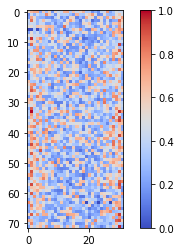

-------------------
hot


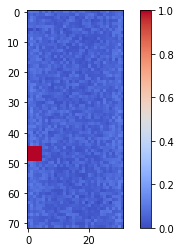

Xtrain.shape after if statement (700, 72, 32, 1)
ytrain.shape after if statement 700
Xval.shape after if statement  (689, 72, 32, 1)
yval.shape after if statement 689
Xtest.shape after if statement (1608, 72, 32, 1)
ytest.shape after if statement 1608
input_shape after if statement (72, 32, 1)


In [9]:

print "X shape is: ",X.shape
#print "y shape is: ",y.shape
print 'Y length is: ',len(Y)
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]
k=0 
maxx=np.max(X[:999])
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1



Xtrain = X[:700]
#ytrain = y[:700]
ytrain = Y[:700]

Xt =  X[700:]
#yt =  y[700:]
Yt = Y[700:]
#Xval, Xtest ,yval, ytest =train_test_split(Xt,yt,test_size=.4,random_state =5 )

Xval, Xtest ,yval, ytest =train_test_split(Xt,Yt,train_size =.3,random_state =5, )
    



print 'Xtrain.shape',Xtrain.shape
print 'ytrain.shape',len(ytrain)#ytrain.shape
print 'Xval.shape',Xval.shape
print 'yval.shape',len(yval)#yval.shape
print 'Xtest.shape',Xtest.shape
print 'ytest.shape',len(ytest)#ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(20,45):
    print'-------------------'
    print ytest[k]
    im=plt.imshow(Xtest[k],cmap='coolwarm')
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xval,input_shape= u.check_test_and_train_images_format(Xtrain, Xval, img_rows, img_cols)


if K.image_data_format() == 'channels_first':
        Xtest = Xtest.reshape(Xtest.shape[0], 1, img_rows, img_cols)
else:
        Xtest = Xtest.reshape(Xtest.shape[0], img_rows, img_cols, 1)
        



print 'Xtrain.shape after if statement',Xtrain.shape
print 'ytrain.shape after if statement',len(ytrain)#ytrain.shape
print 'Xval.shape after if statement ', Xval.shape
print 'yval.shape after if statement',  len(yval)#yval.shape
print 'Xtest.shape after if statement', Xtest.shape
print 'ytest.shape after if statement', len(ytest)#ytest.shape

print 'input_shape after if statement', input_shape

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(input_shape))  # adapt this if using `channels_first` image data format

x = Conv2D(86, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(86, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

#autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')
autoencoder.save('empty_AE.hdf5')
plot_model(autoencoder, to_file='AE_model.png',)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 32, 86)        860       
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 32, 86)        344       
_________________________________________________________________
activation_1 (Activation)    (None, 72, 32, 86)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 16, 86)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 16, 64)        49600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 16, 64)        256       
__________

In [7]:
u.plot_loss(data=history,title="Loss vs Epoch",yscale='linear')

NameError: name 'history' is not defined

# Loading and Evaluating trained model

In [10]:
best_model= load_model(filepath='AE_best_model.hdf5')

In [11]:
pred = best_model.predict(Xtest)
diff = u.makedistancemap(pred,Xtest)

In [12]:
print pred.shape
print diff.shape

(1608, 72, 32, 1)
(1608, 72, 32, 1)


-------------------
[20]
good


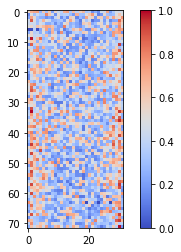

Reconstruction


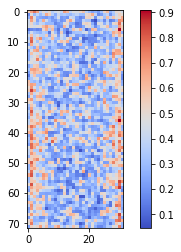

Distance


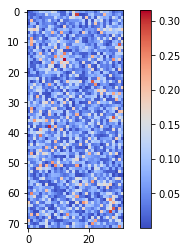

-------------------
[21]
good


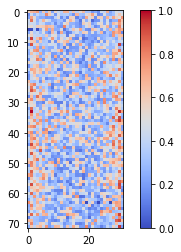

Reconstruction


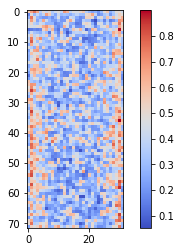

Distance


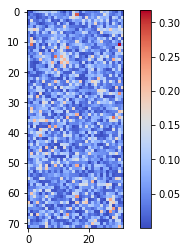

-------------------
[22]
dead


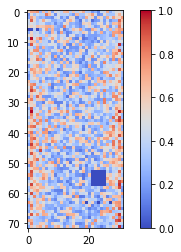

Reconstruction


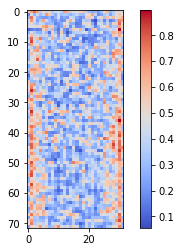

Distance


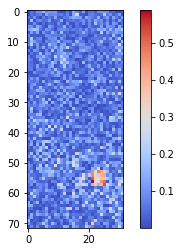

-------------------
[23]
dead


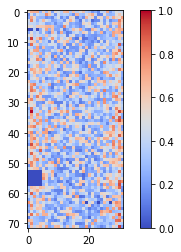

Reconstruction


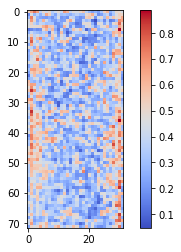

Distance


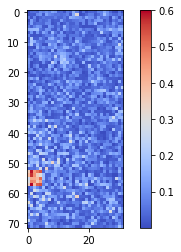

-------------------
[24]
dead


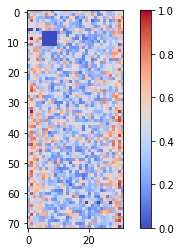

Reconstruction


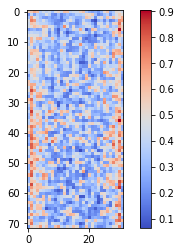

Distance


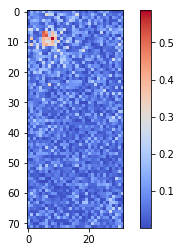

-------------------
[25]
hot


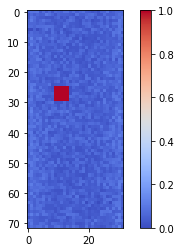

Reconstruction


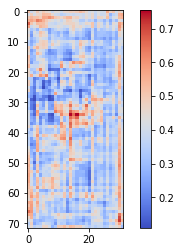

Distance


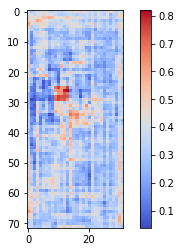

-------------------
[26]
hot


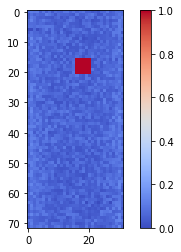

Reconstruction


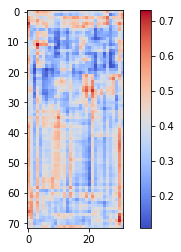

Distance


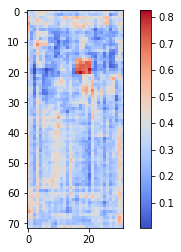

-------------------
[27]
dead


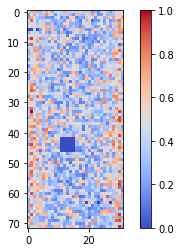

Reconstruction


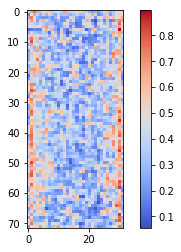

Distance


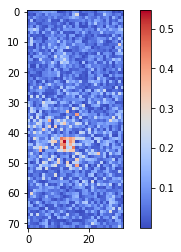

-------------------
[28]
good


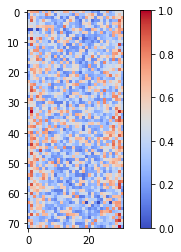

Reconstruction


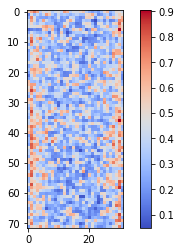

Distance


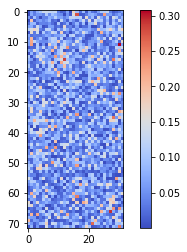

-------------------
[29]
good


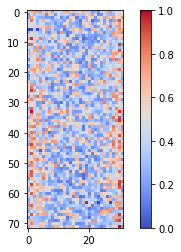

Reconstruction


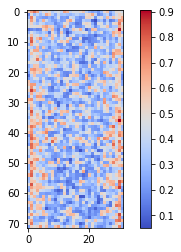

Distance


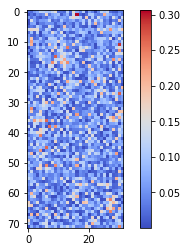

-------------------
[30]
hot


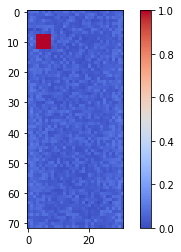

Reconstruction


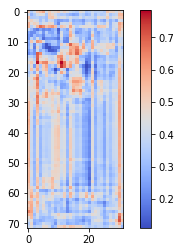

Distance


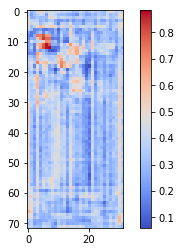

-------------------
[31]
hot


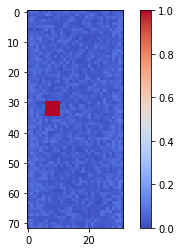

Reconstruction


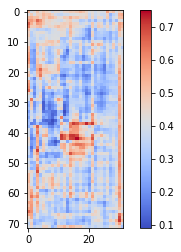

Distance


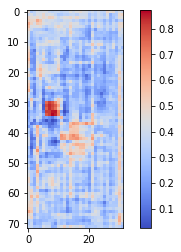

-------------------
[32]
dead


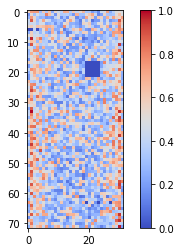

Reconstruction


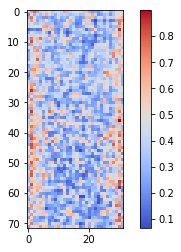

Distance


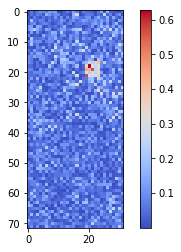

-------------------
[33]
hot


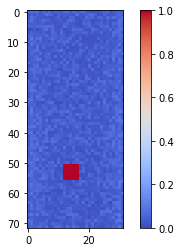

Reconstruction


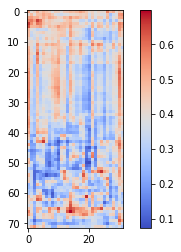

Distance


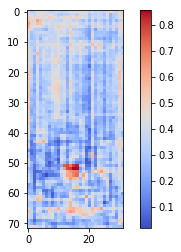

-------------------
[34]
dead


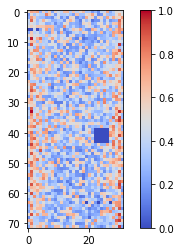

Reconstruction


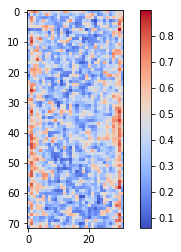

Distance


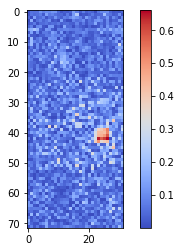

-------------------
[35]
dead


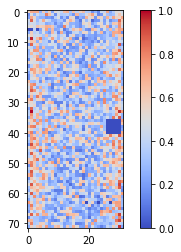

Reconstruction


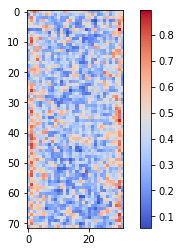

Distance


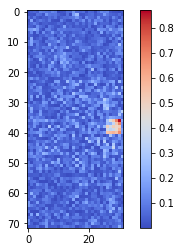

-------------------
[36]
dead


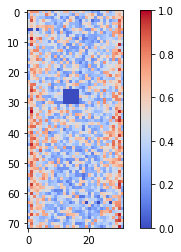

Reconstruction


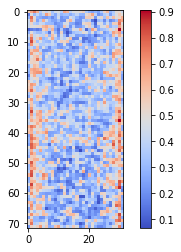

Distance


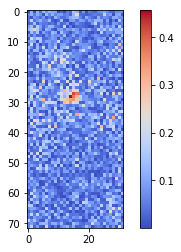

-------------------
[37]
hot


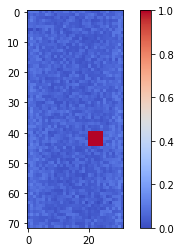

Reconstruction


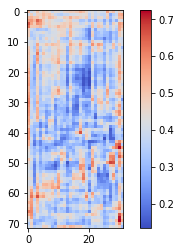

Distance


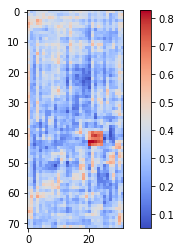

-------------------
[38]
hot


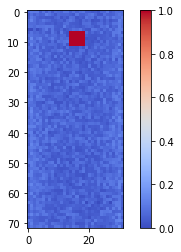

Reconstruction


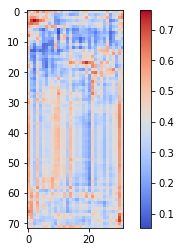

Distance


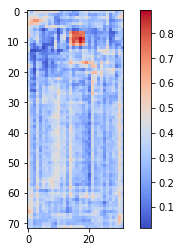

-------------------
[39]
hot


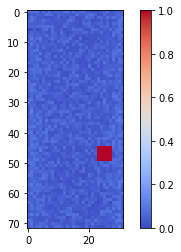

Reconstruction


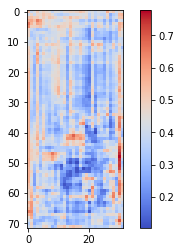

Distance


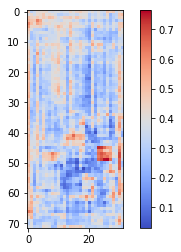

-------------------
[40]
hot


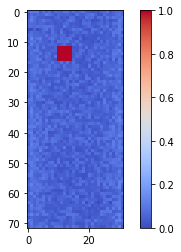

Reconstruction


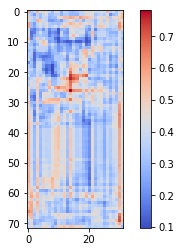

Distance


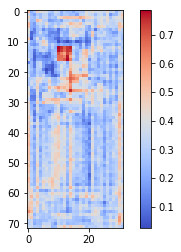

-------------------
[41]
dead


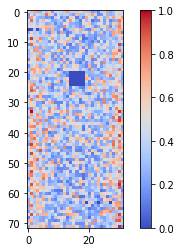

Reconstruction


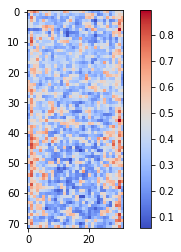

Distance


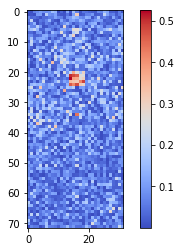

-------------------
[42]
dead


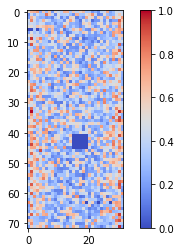

Reconstruction


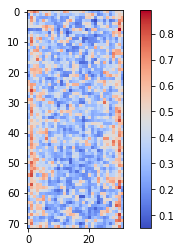

Distance


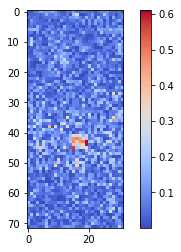

-------------------
[43]
good


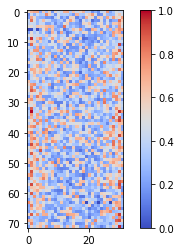

Reconstruction


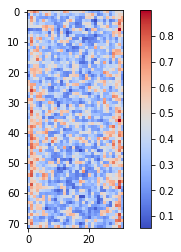

Distance


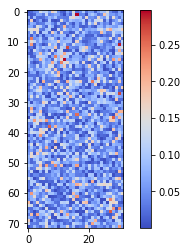

-------------------
[44]
hot


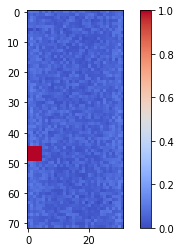

Reconstruction


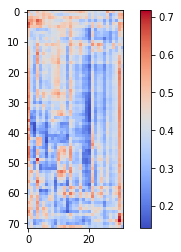

Distance


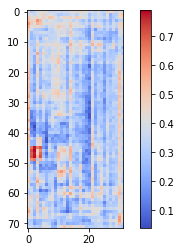

In [23]:
for k in range(20,45):
    print'-------------------'
    print [k]
    print ytest[k]
    im=plt.imshow(np.reshape(Xtest,(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    print 'Reconstruction'
    im=plt.imshow(np.reshape(pred,(pred.shape[0],pred.shape[1],pred.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()
    print 'Distance'
    im=plt.imshow(np.reshape(diff,(diff.shape[0],diff.shape[1],diff.shape[2]))[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


In [14]:
maxerr=[]
for img in diff:
    maxerr.append(np.max(img))
    
print len(maxerr)
#print maxerr.shape

1608


In [ ]:
k=0
print ytest[k]
while True:
    if ytest[k]=='good':
        print k
        k=k+1
    
    elif ytest[k]=='hot':
        print k
        k=k+1
        

hot
0
1
2


(array([ 113.,   75.,    8.,    1.,   15.,   37.,   64.,  106.,  122.,
         116.,   92.,   74.,   72.,   89.,  119.,  150.,  179.,  127.,
          37.,   12.]),
 array([ 0.26713026,  0.30234939,  0.33756852,  0.37278765,  0.40800678,
         0.44322591,  0.47844504,  0.51366417,  0.5488833 ,  0.58410242,
         0.61932155,  0.65454068,  0.68975981,  0.72497894,  0.76019807,
         0.7954172 ,  0.83063633,  0.86585546,  0.90107459,  0.93629372,
         0.97151285]),
 <a list of 20 Patch objects>)

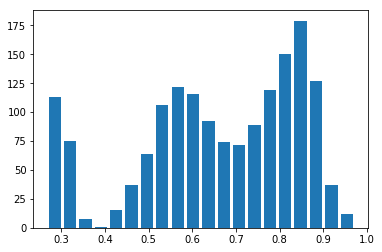

In [16]:
plt.hist(maxerr,bins=20, range=None, density=None, weights=None, cumulative=False, bottom=None,
         histtype=u'bar', align=u'mid', orientation=u'vertical',
         rwidth=.8, log=False, color=None, label=None, stacked=False,
         normed=None, hold=None, data=None)


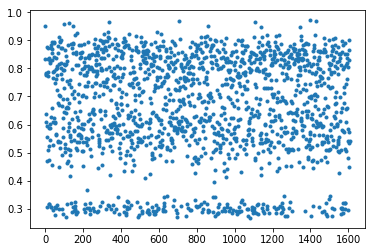

In [18]:
plt.plot(maxerr,'.')